# Final Project
### Team: &emsp;&emsp; Sasi Kanduri &emsp;&emsp; Vikas Mishra &emsp;&emsp; Ashish Kotian

In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [2]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 35.9 MB/s eta 0:00:00


In [ ]:
!unzip /content/drive/MyDrive/mat_files/all_files.zip

## Baseline model

### Converting .mat files to jpg and image arrays
#### The dataset we chose is from https://figshare.com/articles/dataset/brain_tumor_dataset/1512427?file=7953679 has images in .mat files. We have to take the image arrays out of the .mat constructs and pre-process them.

In [36]:
import os
import h5py
import numpy as np
from PIL import Image
import pandas as pd
import cv2
import SimpleITK as sitk
# # List of directories to process
# directories = [
#     'brainTumorDataPublic_1-766',
#     'brainTumorDataPublic_767-1532',
#     'brainTumorDataPublic_1533-2298',
#     'brainTumorDataPublic_2299-3064'
# ]

y_labels = []
filename_column = []

image_arrays = []
image_classes = []
image_size = 256


# Set the paths for the Mat and Jpg folders
mat_folder = f"all_files/all_files"
# jpg_folder = f'./Jpg_images'

# Create the Jpg folder if it doesn't exist
# if not os.path.exists(jpg_folder):
#     os.makedirs(jpg_folder)

# Iterate through files in the Mat folder
for filename in os.listdir(mat_folder):
    # Construct the full file paths
    mat_filepath = os.path.join(mat_folder, filename)
    # jpg_filepath = os.path.join(jpg_folder, filename.split(".")[0] + '.jpg')

    # Open the mat file
    with h5py.File(mat_filepath, 'r+') as f:

        cjdata = f['cjdata']
        image = np.array(cjdata.get('image')).astype(np.float64)
        label = cjdata.get('label')[0, 0]

        if image.shape[0] == 512:

            y_labels.append(label - 1)
            filename_column.append(filename.split(".")[0])

            # Perform image processing
            hi = np.max(image)
            lo = np.min(image)
            image = (((image - lo) / (hi - lo)) * 255).astype(np.uint8)

            image = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_AREA)
            image_arrays.append(image)
            image_classes.append(label - 1)

            # cv2.imwrite(jpg_filepath, image)
            # t1_image = sitk.GetImageFromArray(image)
            # sitk.WriteImage(t1_image, jpg_filepath)


# df = pd.DataFrame({'filename':filename_column, 'label':y_labels})
# df.to_csv('final_df.csv', index=False)

#### Sample image from an image array

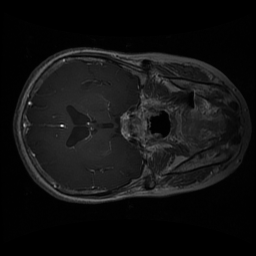

In [37]:
Image.fromarray(image_arrays[0], 'L')

### Data pre-processing

In [38]:
!pip install tensorflow_addons


In [39]:
import numpy as np
from numpy import array
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model, image_dataset_from_directory
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, Rescaling
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


import tensorflow as tf

#### Image arrays got from previous step

In [40]:
image_arrays = np.array(image_arrays).astype(np.uint8)
image_arrays = image_arrays.reshape(image_arrays.shape[0], image_size, image_size, 1)

In [41]:
image_arrays[0]

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

In [42]:
image_classes_encoded = tf.keras.utils.to_categorical(image_classes, 3)
image_classes_encoded = image_classes_encoded.astype(np.uint8)

In [43]:
print(image_arrays.shape)
print(image_classes_encoded.shape)

(3049, 256, 256, 1)
(3049, 3)


### Baseline model from the paper

In [44]:
x_train, x_test, y_train, y_test = train_test_split(image_arrays, image_classes_encoded, test_size=0.20, random_state=42)

In [45]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2439, 256, 256, 1)
(610, 256, 256, 1)
(2439, 3)
(610, 3)


In [54]:
model = Sequential()

model.add(Input(shape=(image_size, image_size, 1)))
model.add(Rescaling(1./255)) # scale pixels)

#1

model.add(Conv2D(64, kernel_size=(5, 5), padding='same', strides=1,
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# 2

model.add(Conv2D(64, kernel_size=(2, 2), padding='same', strides=1,
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# 3

model.add(Conv2D(64, kernel_size=(2, 2), padding='same', strides=1,
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# 4

model.add(Conv2D(64, kernel_size=(2, 2), padding='same', strides=1,
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# 5

model.add(Conv2D(64, kernel_size=(2, 2), padding='same', strides=1,
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# flatten and dense

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 256, 256, 64)      1664      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 128, 128, 64)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 64)      16448     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                

In [55]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

In [57]:
model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test), callbacks=[monitor])

Epoch 1/20
77/77 [==============================] - 6s 50ms/step - loss: 0.7753 - accuracy: 0.6568 - val_loss: 0.6520 - val_accuracy: 0.7197
Epoch 2/20
77/77 [==============================] - 4s 46ms/step - loss: 0.5798 - accuracy: 0.7392 - val_loss: 0.6014 - val_accuracy: 0.7164
Epoch 3/20
77/77 [==============================] - 4s 46ms/step - loss: 0.4606 - accuracy: 0.8011 - val_loss: 0.8077 - val_accuracy: 0.6574
Epoch 4/20
77/77 [==============================] - 4s 46ms/step - loss: 0.3871 - accuracy: 0.8339 - val_loss: 0.8978 - val_accuracy: 0.6574
Epoch 5/20
77/77 [==============================] - 4s 46ms/step - loss: 0.3187 - accuracy: 0.8626 - val_loss: 0.5695 - val_accuracy: 0.7705
Epoch 6/20
77/77 [==============================] - 4s 46ms/step - loss: 0.2443 - accuracy: 0.9024 - val_loss: 0.3845 - val_accuracy: 0.8344
Epoch 7/20
77/77 [==============================] - 4s 46ms/step - loss: 0.2041 - accuracy: 0.9168 - val_loss: 0.3937 - val_accuracy: 0.8508
Epoch 8/20
77

In [58]:
pred = model.predict(x_test)
pred

20/20 [==============================] - 0s 6ms/step


array([[5.21646202e-01, 4.75342810e-01, 3.01097217e-03],
       [3.82299498e-02, 9.61769998e-01, 1.00478381e-08],
       [2.05007358e-03, 9.97917235e-01, 3.27231755e-05],
       ...,
       [6.80000365e-01, 3.19999278e-01, 4.37249440e-07],
       [3.90022160e-06, 1.32116675e-05, 9.99982834e-01],
       [2.23328402e-06, 9.99997020e-01, 7.70693873e-07]], dtype=float32)

In [59]:
y_true = np.argmax(y_test, axis=1)
pred = np.argmax(pred, axis=1)

print(classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.89      0.63      0.74       128
           1       0.85      0.97      0.91       304
           2       0.99      0.95      0.97       178

    accuracy                           0.90       610
   macro avg       0.91      0.85      0.87       610
weighted avg       0.90      0.90      0.89       610



## Hyper tuning to improve the baseline model

### converting the images to 256 x 256

In [56]:
import os
import h5py
import numpy as np
from PIL import Image
import pandas as pd
import cv2
import SimpleITK as sitk
# # List of directories to process
# directories = [
#     'brainTumorDataPublic_1-766',
#     'brainTumorDataPublic_767-1532',
#     'brainTumorDataPublic_1533-2298',
#     'brainTumorDataPublic_2299-3064'
# ]

y_labels = []
filename_column = []

image_arrays = []
image_classes = []
image_size = 256


# Set the paths for the Mat and Jpg folders
mat_folder = f"all_files/all_files"
# jpg_folder = f'./Jpg_images'

# Create the Jpg folder if it doesn't exist
# if not os.path.exists(jpg_folder):
#     os.makedirs(jpg_folder)

# Iterate through files in the Mat folder
for filename in os.listdir(mat_folder):
    # Construct the full file paths
    mat_filepath = os.path.join(mat_folder, filename)
    # jpg_filepath = os.path.join(jpg_folder, filename.split(".")[0] + '.jpg')

    # Open the mat file
    with h5py.File(mat_filepath, 'r+') as f:

        cjdata = f['cjdata']
        image = np.array(cjdata.get('image')).astype(np.float64)
        label = cjdata.get('label')[0, 0]

        if image.shape[0] == 512:

            y_labels.append(label - 1)
            filename_column.append(filename.split(".")[0])

            # Perform image processing
            hi = np.max(image)
            lo = np.min(image)
            image = (((image - lo) / (hi - lo)) * 255).astype(np.uint8)

            image = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_AREA)
            image_arrays.append(image)
            image_classes.append(label - 1)

            # cv2.imwrite(jpg_filepath, image)
            # t1_image = sitk.GetImageFromArray(image)
            # sitk.WriteImage(t1_image, jpg_filepath)


# df = pd.DataFrame({'filename':filename_column, 'label':y_labels})
# df.to_csv('final_df.csv', index=False)

#### Sample image from an image array

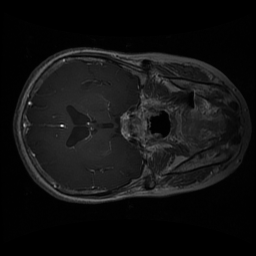

In [57]:
Image.fromarray(image_arrays[0], 'L')

### Data pre-processing

#### Image arrays got from previous step

In [58]:
image_arrays = np.array(image_arrays).astype(np.uint8)
image_arrays = image_arrays.reshape(image_arrays.shape[0], image_size, image_size, 1)

In [59]:
image_arrays.shape

(3049, 256, 256, 1)

In [60]:
image_classes_encoded = tf.keras.utils.to_categorical(image_classes, 3)
image_classes_encoded = image_classes_encoded.astype(np.uint8)

In [61]:
print(image_arrays.shape)
print(image_classes_encoded.shape)

(3049, 256, 256, 1)
(3049, 3)


In [73]:
x_train, x_test, y_train, y_test = train_test_split(image_arrays, image_classes_encoded, test_size=0.20, random_state=42)

In [ ]:
!pip install keras_tuner

#### build model function

In [74]:
import keras_tuner as kt

In [75]:
def build_model(hp):

    model = Sequential()

    model.add(Input(shape=(256, 256, 1)))
    model.add(Rescaling(1./255))  # scale pixels

    # Define the hyperparameters
    num_cnn_layers = hp.Int('num_cnn_layers', min_value=2, max_value=7, step=1)
    activation = hp.Choice('activation', values=['relu', 'gelu', 'tanh'])

    optimizer_choice = hp.Choice('optimizer', values = ['adam', 'sgd'])
    dense_units = hp.Int('dense_units', min_value=256, max_value=1024, step=256)


    # leaving the first layer as it is in the baseline model
    model.add(Conv2D(64, kernel_size=(5, 5), padding='same', strides=1, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    for i in range(num_cnn_layers):
        model.add(Conv2D(64, kernel_size=(2, 2), padding='same', strides=1, activation=activation))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(units=dense_units, activation=activation))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=optimizer_choice, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

### Random Search

In [76]:
checkpointer = ModelCheckpoint(filepath="rs_model.hdf5", verbose=2, save_best_only=True, monitor='val_loss')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='auto')

In [77]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_loss',
    max_trials=20,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    directory='my_dir_rs',
    project_name='my_project_rs'
)


Reloading Tuner from my_dir_rs/my_project_rs/tuner0.json


In [78]:
tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[monitor], batch_size=32)

Trial 20 Complete [00h 03m 19s]
val_loss: 0.24237263202667236

Best val_loss So Far: 0.11293075978755951
Total elapsed time: 00h 52m 16s


In [79]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'num_cnn_layers': 5, 'activation': 'gelu', 'optimizer': 'adam', 'dense_units': 512}


In [80]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], batch_size=32)

Epoch 1/50
76/77 [============================>.] - ETA: 0s - loss: 0.9030 - accuracy: 0.5909
Epoch 1: val_loss improved from inf to 0.71010, saving model to rs_model.hdf5
77/77 [==============================] - 10s 91ms/step - loss: 0.9040 - accuracy: 0.5908 - val_loss: 0.7101 - val_accuracy: 0.7098
Epoch 2/50
 1/77 [..............................] - ETA: 6s - loss: 0.7110 - accuracy: 0.6875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/77 [============================>.] - ETA: 0s - loss: 0.6289 - accuracy: 0.7109
Epoch 2: val_loss improved from 0.71010 to 0.57264, saving model to rs_model.hdf5
77/77 [==============================] - 7s 86ms/step - loss: 0.6282 - accuracy: 0.7114 - val_loss: 0.5726 - val_accuracy: 0.7525
Epoch 3/50
76/77 [============================>.] - ETA: 0s - loss: 0.5385 - accuracy: 0.7599
Epoch 3: val_loss improved from 0.57264 to 0.51738, saving model to rs_model.hdf5
77/77 [==============================] - 7s 86ms/step - loss: 0.5378 - accuracy: 0.7601 - val_loss: 0.5174 - val_accuracy: 0.7705
Epoch 4/50
76/77 [============================>.] - ETA: 0s - loss: 0.4479 - accuracy: 0.7919
Epoch 4: val_loss improved from 0.51738 to 0.44273, saving model to rs_model.hdf5
77/77 [==============================] - 7s 86ms/step - loss: 0.4482 - accuracy: 0.7917 - val_loss: 0.4427 - val_accuracy: 0.8082
Epoch 5/50
76/77 [============================>.] - ETA: 0s - loss: 0.4142 - accuracy: 0.8125

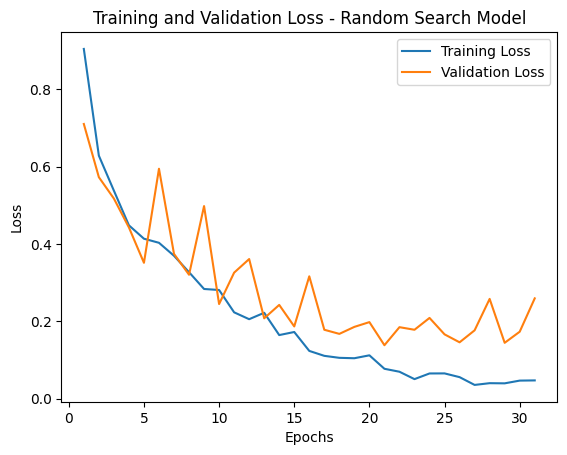

In [81]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')

plt.title('Training and Validation Loss - Random Search Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()


In [82]:
model.load_weights("rs_model.hdf5")
pred = model.predict(x_test)
pred

20/20 [==============================] - 0s 18ms/step


array([[9.8383927e-01, 2.1711702e-04, 1.5943691e-02],
       [2.1920211e-03, 9.9780291e-01, 5.1616971e-06],
       [4.8226636e-02, 9.5164913e-01, 1.2425712e-04],
       ...,
       [9.5611799e-01, 4.3881249e-02, 8.3595768e-07],
       [3.5734331e-05, 7.3713844e-04, 9.9922717e-01],
       [9.3242825e-06, 9.9962330e-01, 3.6738257e-04]], dtype=float32)

In [83]:
y_true = np.argmax(y_test, axis=1)
pred = np.argmax(pred, axis=1)

print(classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       128
           1       0.96      0.97      0.97       304
           2       0.98      0.99      0.98       178

    accuracy                           0.96       610
   macro avg       0.95      0.95      0.95       610
weighted avg       0.96      0.96      0.96       610



In [84]:
rs_model_result = classification_report(y_true, pred, output_dict=True)

### Hyperband

In [85]:
checkpointer = ModelCheckpoint(filepath="hb_model.hdf5", verbose=2, save_best_only=True, monitor='val_loss')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='auto')

In [86]:
tuner = kt.Hyperband(
    hypermodel=build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    directory='my_dir_hb',
    project_name='my_project_hb'
)


In [87]:
tuner.search(x_train, y_train, epochs=30, validation_data=(x_test, y_test), callbacks=[monitor], batch_size=32)

Trial 30 Complete [00h 02m 16s]
val_loss: 0.2296355962753296

Best val_loss So Far: 0.14242056012153625
Total elapsed time: 00h 20m 12s


In [88]:
best_hps_hb = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps_hb.values)

{'num_cnn_layers': 4, 'activation': 'relu', 'optimizer': 'adam', 'dense_units': 768, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0014'}


In [89]:
model = tuner.hypermodel.build(best_hps_hb)
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], batch_size=32)

Epoch 1/50
76/77 [============================>.] - ETA: 0s - loss: 0.8002 - accuracy: 0.6439
Epoch 1: val_loss improved from inf to 0.62298, saving model to hb_model.hdf5
77/77 [==============================] - 6s 53ms/step - loss: 0.7994 - accuracy: 0.6445 - val_loss: 0.6230 - val_accuracy: 0.7197
Epoch 2/50
 1/77 [..............................] - ETA: 3s - loss: 0.6171 - accuracy: 0.6562

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - ETA: 0s - loss: 0.5949 - accuracy: 0.7372
Epoch 2: val_loss did not improve from 0.62298
77/77 [==============================] - 4s 48ms/step - loss: 0.5949 - accuracy: 0.7372 - val_loss: 0.8025 - val_accuracy: 0.6311
Epoch 3/50
77/77 [==============================] - ETA: 0s - loss: 0.4974 - accuracy: 0.7708
Epoch 3: val_loss improved from 0.62298 to 0.49417, saving model to hb_model.hdf5
77/77 [==============================] - 4s 48ms/step - loss: 0.4974 - accuracy: 0.7708 - val_loss: 0.4942 - val_accuracy: 0.7885
Epoch 4/50
77/77 [==============================] - ETA: 0s - loss: 0.3938 - accuracy: 0.8270
Epoch 4: val_loss improved from 0.49417 to 0.45649, saving model to hb_model.hdf5
77/77 [==============================] - 4s 48ms/step - loss: 0.3938 - accuracy: 0.8270 - val_loss: 0.4565 - val_accuracy: 0.8049
Epoch 5/50
77/77 [==============================] - ETA: 0s - loss: 0.3713 - accuracy: 0.8372
Epoch 5: val_loss improved from 0.

In [90]:
model.load_weights("hb_model.hdf5")
pred = model.predict(x_test)
pred

20/20 [==============================] - 0s 7ms/step


array([[9.9726403e-01, 3.4620220e-04, 2.3898047e-03],
       [7.1087085e-02, 9.2890847e-01, 4.3868208e-06],
       [3.0349577e-03, 9.9665350e-01, 3.1152685e-04],
       ...,
       [9.4842130e-01, 5.1545117e-02, 3.3601580e-05],
       [1.5406739e-16, 1.8437162e-13, 1.0000000e+00],
       [3.9201038e-07, 9.9999845e-01, 1.2466668e-06]], dtype=float32)

In [91]:
y_true = np.argmax(y_test, axis=1)
pred = np.argmax(pred, axis=1)

print(classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88       128
           1       0.95      0.94      0.95       304
           2       0.99      0.99      0.99       178

    accuracy                           0.95       610
   macro avg       0.94      0.94      0.94       610
weighted avg       0.95      0.95      0.95       610



In [92]:
hb_model_result = classification_report(y_true, pred, output_dict=True)

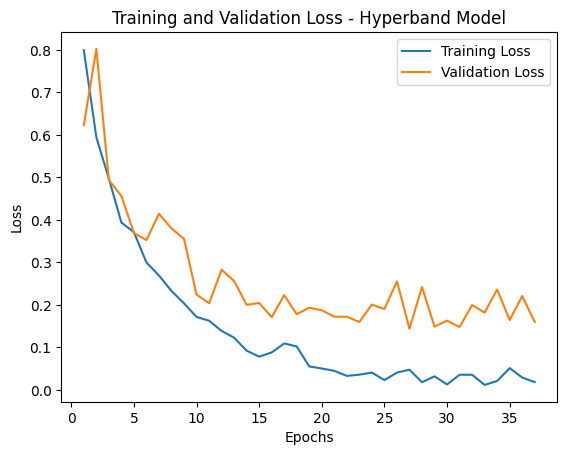

In [93]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')

plt.title('Training and Validation Loss - Hyperband Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()


## Vison Transformer (ViT) model Implementation

#### This model converts the input image into 16x16 patches to be feeded to the encoder block

#### Convert to rgb images for vit model as it is trained predominantly on color images

In [94]:
grayscale_tensors = tf.convert_to_tensor(image_arrays)
rgb_images = tf.image.grayscale_to_rgb(grayscale_tensors)
rgb_images = np.array(rgb_images).astype(np.uint8)

In [95]:
rgb_images[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

#### Split into train and test

In [96]:
x_train, x_test, y_train, y_test = train_test_split(rgb_images, image_classes_encoded, test_size=0.2, shuffle=True, random_state=42)

#### Visualizing the patches for a sample image

In [97]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Patch size: 16 X 16
Patches per image: 256
Elements per patch: 768


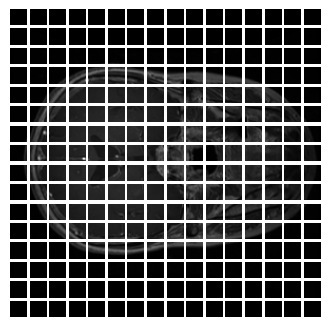

In [98]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([rgb_images[0]]), size = (image_size, image_size)
)

patches = Patches(16)(resized_image)

print(f'Patch size: {16} X {16}')

print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (16, 16, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

###  Building and evaluating ViT model

In [99]:
!pip install vit_keras

In [100]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = (image_size, image_size),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False)

vit_model.summary()

347502902/347502902 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 16, 16, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 256, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 257, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 257, 768)          197376    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 257, 768),        7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [101]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dense(3, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense_4 (Dense)             (None, 128)               98432     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 64)         

In [102]:
checkpointer = ModelCheckpoint(filepath="vit_model.hdf5", verbose=2, save_best_only=True, monitor='val_loss')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='auto')

In [ ]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])


early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)
checkpointer = ModelCheckpoint(filepath="vit_model.hdf5", verbose=2, save_best_only=True, monitor='val_loss')
model.fit(x_train, y_train,
          validation_data = (x_test, y_test),
          epochs = 50,
          callbacks = [early_stopping_callbacks, checkpointer])

Epoch 1/50
77/77 [==============================] - ETA: 0s - loss: 0.9337 - accuracy: 0.6392
Epoch 1: val_loss improved from inf to 0.75563, saving model to base_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 78s 667ms/step - loss: 0.9337 - accuracy: 0.6392 - val_loss: 0.7556 - val_accuracy: 0.8246
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 0.7320 - accuracy: 0.8237
Epoch 2: val_loss improved from 0.75563 to 0.71503, saving model to base_model.hdf5
77/77 [==============================] - 48s 624ms/step - loss: 0.7320 - accuracy: 0.8237 - val_loss: 0.7150 - val_accuracy: 0.8377
Epoch 3/50
77/77 [==============================] - ETA: 0s - loss: 0.7021 - accuracy: 0.8405
Epoch 3: val_loss improved from 0.71503 to 0.70701, saving model to base_model.hdf5
77/77 [==============================] - 48s 626ms/step - loss: 0.7021 - accuracy: 0.8405 - val_loss: 0.7070 - val_accuracy: 0.8262
Epoch 4/50
77/77 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.8622
Epoch 4: val_loss improved from 0.70701 to 0.67096, saving model to base_model.hdf5
77/77 [==============================] - 48s 625ms/step - loss: 0.6724

In [ ]:
model.load_weights('vit_model.hdf5')
pred = model.predict(x_test)

20/20 [==============================] - 4s 175ms/step


In [ ]:
y_true = np.argmax(y_test, axis=1)
pred = np.argmax(pred, axis=1)

print(classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       128
           1       0.96      0.93      0.94       304
           2       0.97      0.98      0.97       178

    accuracy                           0.93       610
   macro avg       0.92      0.93      0.92       610
weighted avg       0.93      0.93      0.93       610

